# Running Deepdreams on Google Colab

# What to expect

## You Are here because:

- You're curious to learn how AI can augment the creative process

## By the end of this tour

**My goal is to help you understand:**
- How using AI art tools can *augment* your creativity
- Aesthetic controls at a deeper level, for one particular technique *(deepdreams)*

## Following along
you may follow along using this interactive notebook hosted on Google Colab: **[Start Here](https://colab.research.google.com/github/andrewlook/tour-of-ai-art/blob/master/notebooks/a_whirlwind_tour_of_ai_art.ipynb#scrollTo=-88s3MpezIVD)**

TODO(look): update this link

# Start here

All you need to do to follow along are a few steps:
1. Save a copy of the Notebook in your own Google Drive account
2. Change runtime to GPU
3. Upload your photo(s) and display them
4. Kick off the longer setup scripts and wait a few mins
5. Test deepdream just to make sure everything works

## Step 1 - Save a copy

If you want to save your notebook to you own Google Drive account. In the top menu, choose **File -> Save a copy in drive** from the top menu when you're ready to save.

## Step 2 - Change Runtime to "GPU"

This makes notebook run much, much faster.

In the top menu, Click **Runtime** and then select **Change Runtime Type**.

Then, click the **Hardware Accelerator** dropdown, select **GPU** and then click **Save**

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/gpu_py2_colab.png" width=400 />

**TODO(look):** fix that image link.

When you're done, running the following code cell should confirm that a GPU is available:


In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import sys
print(sys.version)
assert sys.version.startswith('2')

Found GPU at: /device:GPU:0
2.7.14 (default, Sep 23 2017, 22:06:14) 
[GCC 7.2.0]



> **Colab Hints**
>
> If you want to learn more about how to navigate Colab:
> - [Tensorflow with GPU](https://colab.research.google.com/notebooks/gpu.ipynb)
> - [Loading External Data](https://colab.research.google.com/notebooks/io.ipynb)

> To get a brief overview of Colab's features:
> - [Hello, Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb#scrollTo=-Rh3-Vt9Nev9)
> - [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

## Step 3 - Kick off the longer setup scripts and wait a few mins

There's a bunch of big blobs of code below - if you skip down to a cell below them and run the following, it will execute all cells before that one:
**`<Cmd>-<fn>-F8`**
(Note: you may not need to press `fn` key).

In [2]:
!pip install scikit-image lucid
from __future__ import print_function
from IPython import display as ipyd


    100% |████████████████████████████████| 51kB 4.4MB/s 
    100% |████████████████████████████████| 1.2MB 14.0MB/s 
  Running setup.py bdist_wheel for lucid ... - done
  Stored in directory: /root/.cache/pip/wheels/6f/0d/98/297b00735a83fc189b66d099e1f5ecdbecdebd023d92c1ad0d
  Running setup.py bdist_wheel for pyopengl ... - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58
Successfully built lucid pyopengl


In [3]:
### Tensorflow deepdream model (inception5h)

# first, download a pretrained model to use
import os
if not os.path.exists('inception5h.zip'):
  !wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip inception5h.zip


Redirecting output to ‘wget-log’.
Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 


In [4]:
### Tensorflow Deepdream Code
# - Source: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/deepdream
# - Original notebook: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
#
# Other references:
# - https://github.com/mtyka/deepdream_highres
#
# Source is inlcuded under Apache V2 License:
# - https://github.com/tensorflow/tensorflow/blob/master/LICENSE

# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                s = "<stripped %d bytes>"%size
                tensor.tensor_content = str(s).encode('utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

Number of layers 59
Total number of feature channels: 7548


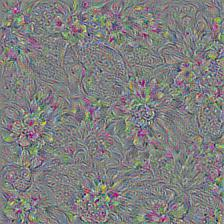

In [5]:
## visualizing neuron activations


# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
    clear_output()
    showarray(visstd(img))
    
    
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize
render_naive(T(layer)[:,:,:,channel])

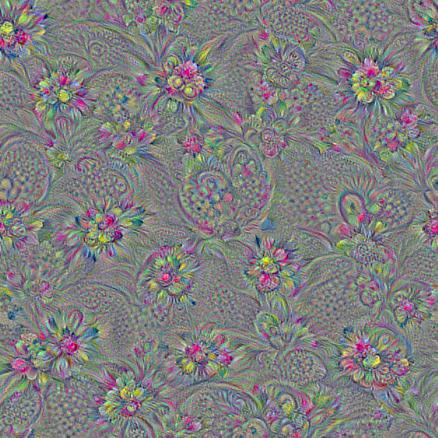

In [6]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)
  
  
def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visstd(img))
        
        
render_multiscale(T(layer)[:,:,:,channel])

In [7]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

  
def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visfunc(img))

# Showing the lap_normalize graph with TensorBoard
lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)
show_graph(lap_graph)


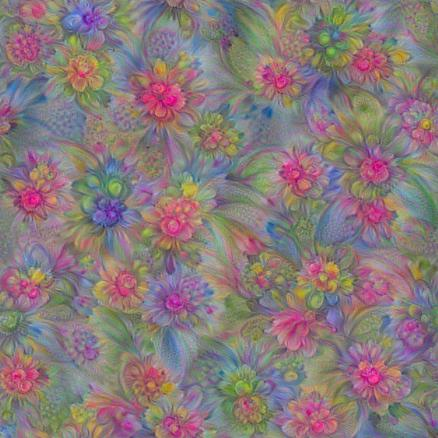

In [8]:
render_lapnorm(T(layer)[:,:,:,channel])

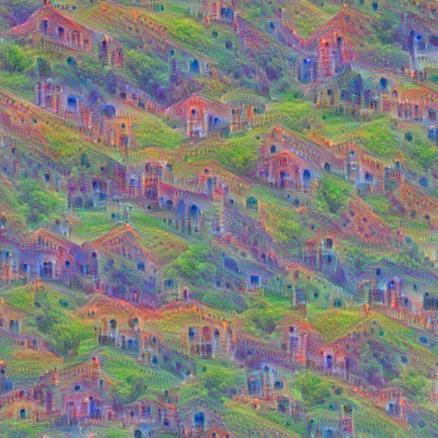

In [9]:
render_lapnorm(T(layer)[:,:,:,65])

In [0]:
def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
        showarray(img/255.0)        

In [11]:
# Semantic Dictionary setup from:
# TODO(look): rem`ove my workaround once the py3 bud gets patched

# - https://github.com/tensorflow/lucid/blob/master/notebooks/building-blocks/SemanticDictionary.ipynb
# Used under Apache V2 License:
# ---------------------------------------------------------------------
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



# TODO(look): remove my "workaround" once the py3 bud gets patched
# !pip uninstall lucid
# !rm -rf /opt/lucid /content/src/lucid && git clone https://github.com/andrewlook/lucid.git /opt/lucid && cd /opt/lucid/ && git checkout py3
# ! cd /opt/lucid && python setup.py --quiet install
# !ls /opt/lucid/lucid/scratch/web/svelte.py
# !cp /opt/lucid/lucid/scratch/web/svelte.py .
# import svelte as lucid_svelte
!pip install --quiet lucid
import lucid.scratch.web.svelte as lucid_svelte

!npm install -g svelte-cli@2.2.0

import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.showing import _image_url


/tools/node/bin/svelte -> /tools/node/lib/node_modules/svelte-cli/bin.js
+ svelte-cli@2.2.0
added 2 packages from 1 contributor in 2.076s


In [12]:
%%html_define_svelte SemanticDict

<div class="figure">
    <div class="input_image">
        <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        <svg class="pointer_container" viewBox="0 0 {{N[0]}} {{N[1]}}">

            {{#each xs as x}}
            {{#each ys as y}}
              <rect x={{x}} y={{y}} width=1 height=1
                class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                on:mouseover="set({pos: [x,y]})"></rect>
            {{/each}}
            {{/each}}
        </svg>
    </div>
    <div class="dict" >
        {{#each present_acts as act, act_ind}}
        <div class="entry">
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(act.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>
            <div class="value" style="height: {{sprite_size*act.v/1000.0}}px;"></div>
        </div>
        {{/each}}
    </div>
</div>


<style>
    .figure {
        padding: 10px;
        width: 1024px;
    }
    .input_image {
        display: inline-block;
        width: 224px;
        height: 224px;
    }
    .input_image .image, .input_image .pointer_constainer {
        position: absolute;
        width: 224px;
        height: 224px;
        border-radius: 8px;
    }
    .pointer_container rect {
      opacity: 0;
    }
    .pointer_container .selected {
      opacity: 1;
      fill: none;
      stroke: hsl(24, 100%, 50%);
      stroke-width: 0.1px;
    }
    
    .dict {
        height: 128px;
        display: inline-block;
        vertical-align: bottom;
        padding-bottom: 64px;
        margin-left: 64px;
    }
    .entry {
        margin-top: 9px;
        margin-right: 32px;
        display: inline-block;
    }
    .value {
        display: inline-block;
        width: 32px;
        border-radius: 8px;
        background: #777;
    }
    .sprite {
        display: inline-block;
        border-radius: 8px;
    }
    .dict-text {
        display: none;
        font-size: 24px;
        color: #AAA;
        margin-bottom: 20px;
    }
</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 64,
        sprite_n_wrap: 1e8,
        image_url: "",
        activations: [[[{n: 0, v: 1}]]],
        pos: [0,0]
      };
    },
    computed: {
      present_acts: (activations, pos) => activations[pos[1]][pos[0]],
      N: activations => [activations.length, activations[0].length],
      xs: (N) => range(N[0]),
      ys: (N) => range(N[1])
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_4iB5iV/SemanticDict_7e96969f_bab4_486d_8690_b0be83d9e960.html > /tmp/svelte_4iB5iV/SemanticDict_7e96969f_bab4_486d_8690_b0be83d9e960.js
svelte version 1.64.1
compiling ../tmp/svelte_4iB5iV/SemanticDict_7e96969f_bab4_486d_8690_b0be83d9e960.html...



In [0]:
layer_spritemap_sizes = {
    'mixed3a' : 16,
    'mixed3b' : 21,
    'mixed4a' : 22,
    'mixed4b' : 22,
    'mixed4c' : 22,
    'mixed4d' : 22,
    'mixed4e' : 28,
    'mixed5a' : 28,
  }

def googlenet_spritemap(layer):
  assert layer in layer_spritemap_sizes
  size = layer_spritemap_sizes[layer]
  url = "https://storage.googleapis.com/lucid-static/building-blocks/googlenet_spritemaps/sprite_%s_channel_alpha.jpeg" % layer
  return size, url

googlenet = models.InceptionV1()
googlenet.load_graphdef()


def googlenet_semantic_dict_from_url(layer, img_url):
    img = load(img_url)
    googlenet_semantic_dict(layer, img)
    
# ## **User facing constructor**
# Now we'll create a convenient API for creating semantic dictionary
# visualizations. It will compute the network activations for an image,
# grab an appropriate spritemap, and render the interface.
def googlenet_semantic_dict(layer, img):    
    # Compute the activations
    with tf.Graph().as_default(), tf.Session():
        t_input = tf.placeholder(tf.float32, [224, 224, 3])
        T = render.import_model(googlenet, t_input, t_input)
        acts = T(layer).eval({t_input: img})[0]
    
    # Find the most interesting position for our initial view
    max_mag = acts.max(-1)
    max_x = np.argmax(max_mag.max(-1))
    max_y = np.argmax(max_mag[max_x])
    
    # Find appropriate spritemap
    spritemap_n, spritemap_url = googlenet_spritemap(layer)
    
    # Actually construct the semantic dictionary interface
    # using our *custom component*
    lucid_svelte.SemanticDict({
        "spritemap_url": spritemap_url,
        "sprite_size": 110,
        "sprite_n_wrap": spritemap_n,
        "image_url": _image_url(img),
        "activations": [[[{"n": n, "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]] for act_vec in act_slice] for act_slice in acts],
        "pos" : [max_y, max_x]
    })
   
   


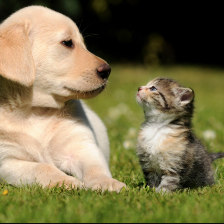

In [16]:
googlenet_semantic_dict_from_url("mixed4d", "https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")

In [0]:
###### Image setup code.

In [0]:
# basic image mgmt functions
from __future__ import print_function
import numpy as np
import PIL

from IPython import display as ipyd
from lucid.misc.io import reading, showing
from skimage import io
# http://scikit-image.org/docs/dev/api/skimage.transform.html
from skimage import transform
from IPython import display as ipyd

# from https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
def crop_center(img, cropx, cropy):
    y, x, _ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)    
    return img[starty:starty+cropy, startx:startx+cropx, :]
 
def square_shrink(img, dim):
  smaller_dim = min(img.shape[:2])
  cropped = crop_center(img, smaller_dim, smaller_dim)
  small_cropped = transform.resize(cropped, (dim, dim, img.shape[2]), mode='constant')
  return small_cropped

def load_img(fname, dim=None):
  img = io.imread(fname)
  if not dim:
    return transform.resize(img, (img.shape[0], img.shape[1], img.shape[2]), mode='constant')
  small_img = square_shrink(img, dim=dim)
  return small_img

def upload_images():
  from google.colab import files
  uploaded = files.upload()
  img_fnames = []
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    img_fnames.append(fn)
  return img_fnames


### Jump down here and run all setup cells at once

run the following, it will execute all cells before that one:
**`<Cmd>-<fn>-F8`**
(Note: you may not need to press `fn` key).

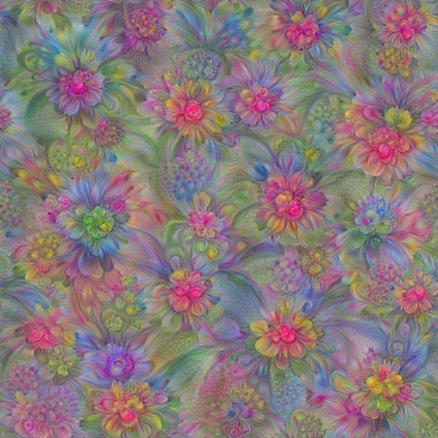

In [17]:
# First run <Cmd>-<fn>-F8, to run all cells before this one.

# While you're waiting, you can hit <Shift>-Enter in this cell,
# and it will generate some output to verify that everything got set
# up correctly.

### Test deepdream just to make sure everything works
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize
render_naive(T(layer)[:,:,:,channel])
render_multiscale(T(layer)[:,:,:,channel])
render_lapnorm(T(layer)[:,:,:,channel])


## Step 4 - Upload your photo(s) and display them




In [20]:
# run this to display file upload form, and click "Choose Files"
image_filenames = upload_images()

Saving j1.png to j1.png
Saving j2.png to j2.png
User uploaded file "j2.png" with length 729141 bytes
User uploaded file "j1.png" with length 320145 bytes



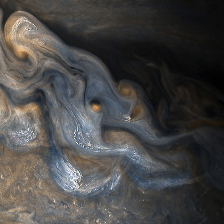
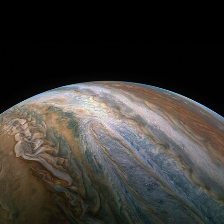


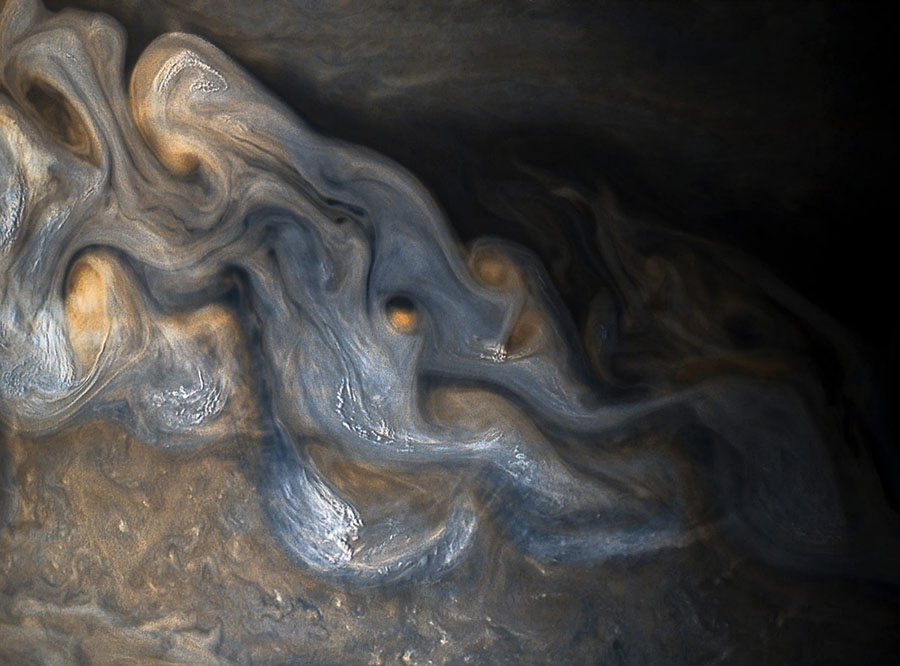
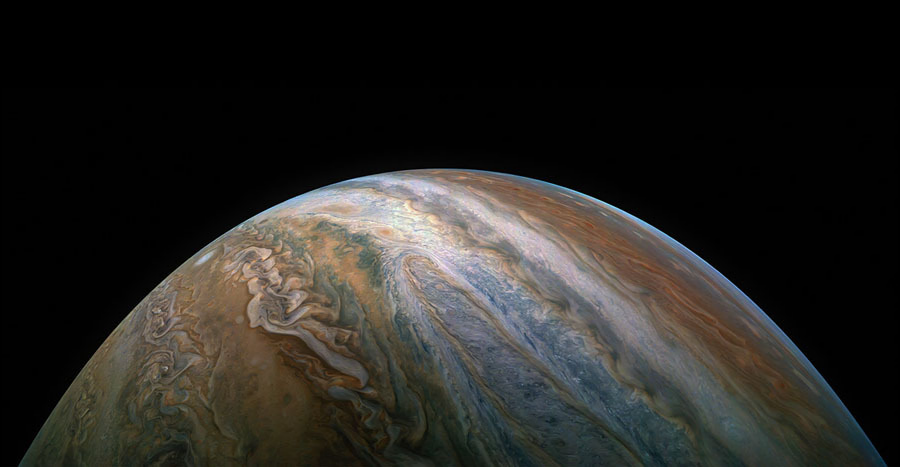

In [21]:
# since images can be pretty large (and slow down the notebook to render them),
# it's handy to have some lower-res versions to quickly experiment with.
small_imgs = [load_img(f, dim=224) for f in image_filenames]
# use a helper from lucid to display the images neatly:
showing.images(small_imgs, labels=image_filenames)

# also load the full images, in case you want a high-res deepdream
large_imgs = [load_img(f) for f in image_filenames]
showing.images(large_imgs, labels=image_filenames, w=400)

# for the rest of the notebook to go smoothly, we'll keep a pointer to the first
# images that we loaded:
small_img_0 = small_imgs[0]
large_img_0 = large_imgs[0]

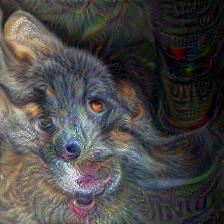

In [22]:
small_new_img = render_deepdream(tf.square(T('mixed4c')), small_img_0*255)

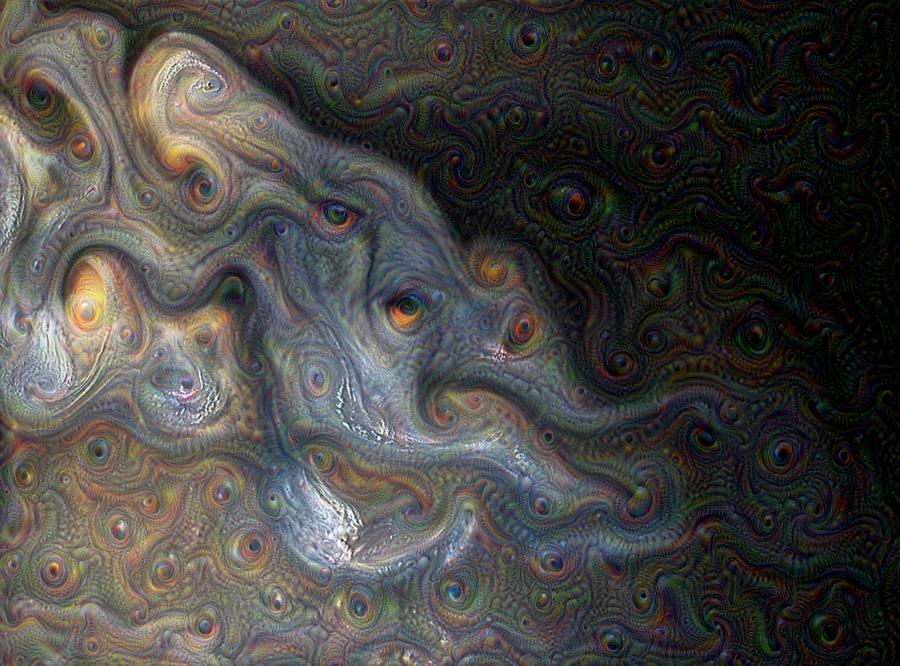

In [23]:

new_img = render_deepdream(tf.square(T('mixed4c')), large_img_0*255)

# Background on deepdreams

This tool arose from trying to **understand what Neural Networks "see".**

One way to do this is by understanding which area of the image caused the prediction:

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/attribution.png" width=400 />

source: [distill.pub](https://distill.pub/2017/feature-visualization/)

---

Instead, the a-ha moment for the deepdream authors was that we could get the neural network to "hallucinate" and how us *"what picture would make this look more like X"*?

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/featureviz.png" width=400 />


> Pareidolia is a type of apophenia, which is a more generalized term for seeing patterns in random data. Some common examples are seeing a likeness of Jesus in the clouds or an image of a man on the surface of the moon. 
>
> -- [source](https://www.livescience.com/25448-pareidolia.html)

<img src="https://img.purch.com/w/640/aHR0cDovL3d3dy5saXZlc2NpZW5jZS5jb20vaW1hZ2VzL2kvMDAwLzAzNC8zNDMvaTAyL3JvcnNjaGFjaC0wMi5qcGc/MTM1NTI2Njg4MA==" widht=400 />

# Deliberately Crafting an Effect

<img src="https://cdn-images-1.medium.com/max/1600/1*3rECTefgSkJJ6Sni5sxptA.png" width=600 />

## My Work: exploring high and low layers

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/n2.jpg" width=400/>

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/n3.jpg" width=400/>

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/IMG_5907.jpg" width=400 />

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/IMG_7101.JPG" width=400 />



<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/naptime_mixed3a_i30.jpeg" width=400 />

## How does it work?

In [0]:
# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)


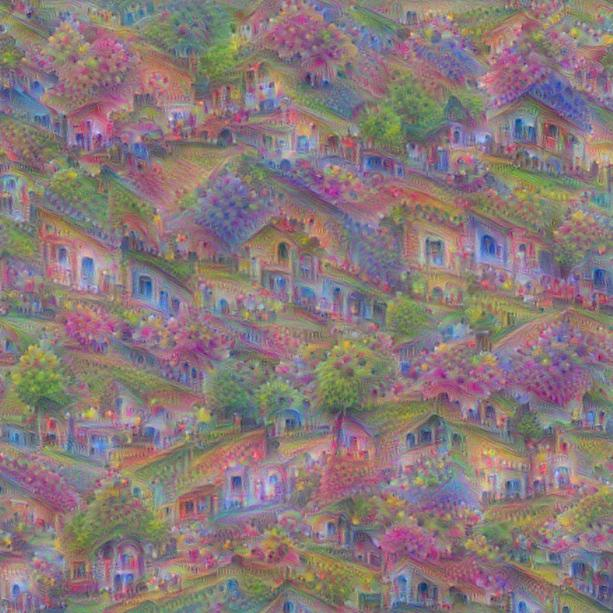

In [24]:
mixed4d = 'mixed4d_3x3_bottleneck_pre_relu'
mixed4d_65 = render_lapnorm(T(mixed4d)[:,:,:,65])

# Lower layers produce features of lower complexity.
mixed3b_101 = render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,101])

# optimizing a linear combination of features often gives a "mixture" pattern.
combo__mixed4d_65__mixed3b_101 = render_lapnorm(T(mixed4d)[:,:,:,65]+T(mixed4d)[:,:,:,139], octave_n=4)

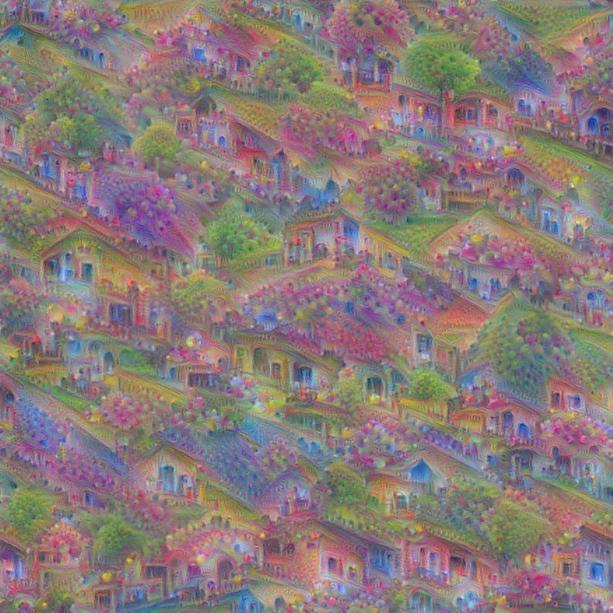

In [25]:
#### TF RUN CODE


render_lapnorm(T(layer)[:,:,:,65])

# Lower layers produce features of lower complexity.
render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,101])

# optimizing a linear combination of features often gives a "mixture" pattern.
render_lapnorm(T(layer)[:,:,:,65]+T(layer)[:,:,:,139], octave_n=4)

